In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision
import time
import os

### 1. VGGNet with PyTorch

### Implementing VGGNet

> 1. **Dataset**
>> - Images from the first three categories in CIFAR-10. (Due to the computational constraints.)  <br>
     Three categories : plane, car, bird  /  The number of training images : 15,000   /  The number of test images : 3,000
>> - Augmented with flipping and random cropping.
>
> 2. **Network architecture**
>> - Type-D configuration in the paper (+ 3-way classifier after convolutional layers).
>> - ReLU activation.
>> - No dropout for simplicity.
>> - We will apply **batch-normalization** after every convolution which is not used in the paper (otherwise, hard to optimize).
>> - **Conv2d -> BatchNorm2d -> ReLU**
>>
>> <table><tr>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1OiTmrplD9gOrEJizLChyLp31R0QtoeHv" alt="no_image" style="width: 550px;"/> </td>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1bBvAOdJeskMMyOrZtBCCnkEEgq9PgjX9" alt="no_image" style="width: 250px;"/> </td>
>> </tr></table>
>>
>> <font size="0.5"> Figure from <br>
>> [1] https://www.quora.com/What-is-the-VGG-neural-network </font>
>
> 3. **Loss function**
>> - Cross-entropy loss between outputs & ground-truths. <br>
     Note that `nn.CrossEntroyLoss` takes logits before softmax as network outputs and scalar index (not one-hot vector) as ground-truths.<br>
     See https://pytorch.org/docs/stable/nn.html#crossentropyloss for details.
>
> 4. **Training**
>> - Default weight initialization for simplicity.
>> - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
>> - 20 epochs without learning rate scheduling.
>
> 5. **Evaluation metric**
>> - Classification accuracy (i.e., the percentage of correct predictions).
>
>

In [2]:
print('STEP 1: LOADING DATASET')
# CIFAR-10 dataset을 Load & Transform
# torchvision.transforms 를 이용하여 전처리
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # 32 * 32 크기로 무작위로 자름 (주변에 padding 4 추가)
    transforms.RandomHorizontalFlip(), # 무작위로 좌우 반전
    transforms.ToTensor(), # Tensor로 변환 (0 ~ 1 범위로 정규화 됨)
    transforms.Normalize((0.4194, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # 정규화 (평균 및 표준편차를 기준으로 정규화)
])

transform_test = transforms.Compose([
    transforms.ToTensor(), # Test data는 변형 없이 원본 이미지 그대로 사용해야 일관된 평가 가능
    transforms.Normalize((0.4194, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # 정규화만 적용 (데이터 증강 x)
])

train_dataset = dsets.CIFAR10(root='./data/CIFAR10/',
                              train=True,
                              transform=transform_train,
                              download=True)

test_dataset = dsets.CIFAR10(root='./data/CIFAR10/',
                             train=False,
                             transform=transform_test)

STEP 1: LOADING DATASET
Files already downloaded and verified


In [3]:
# CIFAR-10 dataset에서 레이블이 0, 1, 2 인 데이터만 선택하여 축소된 dataset을 생성
reduced_train_dataset = []
for images, labels in train_dataset:
  if labels < 3:
    reduced_train_dataset.append((images, labels))

reduced_test_dataset = []
for images, labels in test_dataset:
  if labels < 3:
    reduced_test_dataset.append((images, labels))

In [4]:
print("The number of training images: ", len(reduced_train_dataset))
print("The number of test images: ", len(reduced_test_dataset))

The number of training images:  15000
The number of test images:  3000


In [5]:
print("STEP 2: MAKING DATASET ITERABLE")
# CIFAR-10 dataset을 batch 단위로 load 할 수 있도록 DataLoader를 생성
# train_loader: train data를 128개씩 랜덤 배치로 로드
train_loader = torch.utils.data.DataLoader(dataset=reduced_train_dataset,
                                           batch_size=128,
                                           shuffle=True) # 모델이 특정 순서에 과적합되지 않도록 데이터 순서를 무작위로 만듦
# test_loader = test data를 100개씩 순서를 유지하며 로드
test_loader = torch.utils.data.DataLoader(dataset=reduced_test_dataset,
                                          batch_size=100,
                                          shuffle=False) # 테스트 데이터는 항상 같은 순서로 평가해야 하므로 섞지 않음
# CIFAR-10 은 10개의 클래스로 구성된 데이터 셋
# 각 인덱스에 해당하는 클래스 이름을 튜플로 저장
class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

STEP 2: MAKING DATASET ITERABLE


### Visualize a few images

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [7]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0)) # PyTorch Tensor -> Numpy 배열로 변환
  # PyTorch 이미지 Tensor는 (채널, 높이, 너비) 순서이므로 Matplotlib에서 올바르게 표시되도록 (높이, 너비, 채널) 로 변환
  mean = np.array([0.4194, 0.4822, 0.4465]) # 이미지 정규화를 적용했으므로 이를 다시 원래 값으로 복원
  std = np.array([0.2023, 0.1994, 0.2010])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1) # 이미지 픽셀 값이 0 ~ 1 범위를 벗어나지 않도록 조정
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

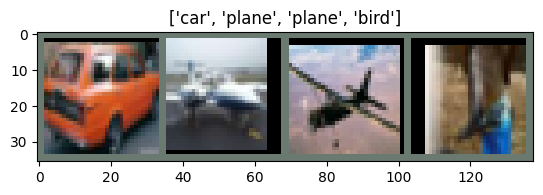

In [8]:
train_loader_sample = torch.utils.data.DataLoader(dataset=reduced_train_dataset,
                                                  batch_size=4,
                                                  shuffle=True)

inputs, classes = next(iter(train_loader_sample))
# inputs: 배치 내 4개의 이미지 Tensor
# classes: 각 이미지에 대한 클래스 라벨(숫자)
out = torchvision.utils.make_grid(inputs) # 4개의 이미지를 한 장의 이미지로 합쳐서 그리드 형태로 표시, 이미지 간 패딩을 추가하여 하나의 큰 이미지로 정렬
imshow(out, title=[class_names[x] for x in classes])

### VGG 16

In [12]:
print("STEP 3: CREATE MODEL CLASS (VGG16)")

cfg = [64, 64, 'MP', 128, 128, 'MP', 256, 256, 256, 'MP', 512, 512, 512, 'MP', 512, 512, 512, 'MP'] # VGG16의 계층 구조 정의

class VGG(nn.Module):
  def __init__(self, in_channels=3):
    super(VGG, self).__init__()
    self.VGG16 = self._make_layers(cfg, in_channels) # VGG16 모델의 CNN 부분을 구성
    self.classifier = nn.Linear(512, 3) # Fully Connected Layer (출력 크기: num_classes=3)

  def forward(self, x): # Forward Propagation
    out = self.VGG16(x) # CNN 계층을 통과
    out = out.view(out.size(0), -1) # Feature Map을 1D 벡터로 펼침 (Flatten)
    out = self.classifier(out) # Fully Connected Layer 통과 후 최종 예측값 반환
    # FC Layer를 거쳐 3개의 클래스에 대한 예측값(logit)을 출력
    return out

  def _make_layers(self, cfg, in_channels):
    layers = []

    for x in cfg:
      if x == 'MP':
        layers.append(nn.MaxPool2d(kernel_size=2))
      else:
        layers.append(nn.Conv2d(in_channels=in_channels, out_channels=x, kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(x))
        layers.append(nn.ReLU())
        in_channels=x

    return nn.Sequential(*layers) # 모든 layer 를 Sequential 로 묶어서 하나의 모듈로 반환 (CNN 모델의 여러 계층을 하나의 연속된 블록으로 정의하기 위함)
    # 각 계층이 자동으로 순서대로 실행됨

# Feature map 의 개수는 channel 수와 같다
# Feature map = CNN이 kernel을 사용하여 이미지의 특징을 추출한 결과 (각 필터는 서로 다른 특징)

STEP 3: CREATE MODEL CLASS (VGG16)


In [13]:
print('STEP 4: INSTANTIATE MODEL CLASS')
# 모델 인스턴스화 및 파라미터 개수 계산
# VGG 모델을 생성하고, GPU 또는 CPU에 로드하는 과정
model = VGG()
num_total_params = sum(p.numel() for p in model.parameters()) # 모델 내부의 모든 가중치 및 편향 (weight & bias) 텐서를 가져옴
# p.numel(): 해당 가중치 tensor의 총 파라미터 개수 반환
print("The number of parameters : ", num_total_params)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  14724675


VGG(
  (VGG16): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [14]:
print("STEP 5: INSTANTIATE LOSS CLASS")
criterion = nn.CrossEntropyLoss() # 분류 문제에서 사용되는 손실 함수, 다중 클래스 분류에서 자주 사용됨
# 내부적으로 Softmax + Negative Log Likelihood Loss 를 포함
# 모델이 예측값 (logits)와 실제 정답 (class index)를 비교하여 오차 계산
print("STEP 6: INSTANTIATE OPTIMIZER CLASS")

learing_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4

optimizer = torch.optim.SGD(model.parameters(), lr=learing_rate, momentum = momentum, weight_decay = weight_decay)
# 확률적 경사 하강법 (Stochastic Gradient Descent), 모델의 모든 파라미터 업데이트, weight_decay -> L2 정규화
# SGD -> Loss Function 을 줄이기 위해 가중치를 업데이트하는 알고리즘. 기울기를 계산하여 반대 방향으로 이동

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS


### Train the VGG 16 model and print test accuracy for every epochs

In [15]:
# 모델 학습 및
# 훈련 데이터: 전체 데이터를 batch_size=128로 쪼갬, 한 번의 배치에서 128개씩 모델이 학습. 총 391 번의 배치가 실행되면 1 에포크 종료
# 테스트 데이터: 전체 데이터를 batch_size=100으로 쪼갬, 한 번의 배치에서 100개씩 모델이 예측 총 100 번의 배치가 실행되면 테스트 완료
import time
print('STEP 7: TRAIN THE MODEL')
num_epochs = 20
# 1 Epoch = 전체 데이터 한 바퀴
for epoch in range(num_epochs): # 전체 데이터세을 num_epochs 만큼 반복 학습
  start_time = time.time()
  for i, (images, labels) in enumerate(train_loader): # 배치 단위로 학습, 한 번의 배치에서 128개씩 모델이 학습
# Training Loop
   images = images.to(device)
   labels = labels.to(device)
   optimizer.zero_grad() # 이전 기울기 초기화
   outputs = model(images) # 순전파 실행
   loss = criterion(outputs, labels) # 손실 계산
   loss.backward() # 역전파를 수행하여 가중치에 대한 기울기 계산
   optimizer.step() # 가중치 업데이트
  correct = 0
  total = 0
  for images, labels in test_loader:
# Test Loop
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images) # 모델이 예측한 결과
    _, predicted = torch.max(outputs.data, 1) # 예측값 중 가장 높은 확률을 가진 클래스 선택
    total += labels.size(0)
    correct += (predicted == labels).sum() # 맞춘 개수를 합산
  end_time = time.time()
  accuracy = 100 * correct.item() / total # 정확도 계산
  elapsed_time = end_time - start_time
  print('Epochs: {}. Loss: {}. Accuracy: {}, Elapsed time: {} sec'.format(epoch, loss.item(), accuracy, elapsed_time))

STEP 7: TRAIN THE MODEL
Epochs: 0. Loss: 0.6413388848304749. Accuracy: 82.5, Elapsed time: 7.634923219680786 sec
Epochs: 1. Loss: 0.30767199397087097. Accuracy: 86.36666666666666, Elapsed time: 6.62676215171814 sec
Epochs: 2. Loss: 0.7385739684104919. Accuracy: 87.56666666666666, Elapsed time: 6.6397929191589355 sec
Epochs: 3. Loss: 0.20916219055652618. Accuracy: 90.1, Elapsed time: 6.6617913246154785 sec
Epochs: 4. Loss: 0.2061227411031723. Accuracy: 89.56666666666666, Elapsed time: 6.666800022125244 sec
Epochs: 5. Loss: 0.1492268145084381. Accuracy: 90.26666666666667, Elapsed time: 6.707655906677246 sec
Epochs: 6. Loss: 0.07712143659591675. Accuracy: 91.76666666666667, Elapsed time: 6.74907922744751 sec
Epochs: 7. Loss: 0.14920081198215485. Accuracy: 91.46666666666667, Elapsed time: 6.797206163406372 sec
Epochs: 8. Loss: 0.04695770516991615. Accuracy: 89.33333333333333, Elapsed time: 6.841727018356323 sec
Epochs: 9. Loss: 0.1836860030889511. Accuracy: 91.46666666666667, Elapsed time:

In [9]:
from PIL import Image
img = Image.open('/content/m4.jpeg')

t = transforms.Compose([
    transforms.Resize((32, 32)),  # VGG 입력 크기 맞추기
    transforms.ToTensor(),          # Tensor 변환
    transforms.Normalize(mean=[0.4194, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])  # 정규화
    # 입력 데이터를 정규화하는 과정
    # 정규화 - 각 픽셀 값을 일정한 범위로 조정하는 과정. 보통 딥러닝 모델에서는 픽셀 값을 평균 0, 표준편차 1에 가깝게 정규화하면 학습이 더 잘된다
    # 위 값들은 훈련 데이터셋(CIFAR-10)에서 R, G, B 채널별 평균과 표준편차를 미리 계산한 값이다 (전체 데이터셋에서 R, G, B 채널별 평균과 표준편차를 계산한 값)
])

img_tensor = t(img) # 변환 적용
img_tensor = img_tensor.unsqueeze(0) # 배치 차원 추가 (1, 3, 224, 224)

img_tensor = img_tensor.to(device)
outputs = model(img_tensor)

_, predicted = torch.max(outputs.data, 1)

print(class_names[predicted])

FileNotFoundError: [Errno 2] No such file or directory: '/content/m4.jpeg'

## 2. ResNet with PyTorch

### Implementing ResNet

> 1. **Dataset**
>> - The same dataset used for VGGNet
>
> 2. **Network architecture**
>> - 50-layer ResNet with **bottleneck blocks**. <br>
     Note. The initial convolution layer (i.e., conv1) is different from the one in the paper &<br>
     the initial max-pooling layer is removed (because the size of CIFAR-10 images is too small).
>> - ReLU activation.
>> - Strided convolution for down-sampling instead of max-pooling layer. <br>
     Note. Once down-sampled, a $1\times1$ convolution/stride 2 is applied to residual for expanding the channel of the residual.
>> - No dropout for simplicity.
>> - Batch-normalization after every convolution.
>>
>>
>> <table><tr>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1ZYDfpVBFBvQnVezVcJqRxwh09rUVmxwD" alt="no_image" style="width: 500px;"/> </td>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1JNEea1G-5yOKVLmSCkiYAEJ0HXOys0CR" alt="no_image" style="width: 300px;"/> </td>
>> </tr></table>
>>
>> <img src="https://docs.google.com/uc?export=download&id=1vY0ys5KAZmMlOKk8Dcv7eAV8pZ9cawzJ" alt="no_image" style="width: 870px;"/>
>>
>> <font size="0.5"> Figures from <br>
>> [1] https://www.codeproject.com/Articles/1248963/Deep-Learning-using-Python-plus-Keras-Chapter-Re  <br>
>> [2] Rezende et al., *Signal Processing: Image Communication*, 2018. </font>
>
> 3. **Loss function**
>> - Cross-entropy loss between outputs & ground-truths. <br>
>
> 4. **Training**
>> - Default weight initialization for simplicity.
>> - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
>> - 15 epochs without learning rate scheduling.
>
> 5. **Evaluation metric**
>> - Classification accuracy (i.e., the percentage of correct predictions).
>
>

### Implement ResNet50 and train it with the CIFAR 10 dataset

In [13]:
print("STEP 3: CREATE MODEL CLASS (ResNet-50)")
cfg = [3, 4, 6, 3]

class ResNet_block(nn.Module):
  def __init__(self, in_c, intra_c, out_c, down_sample=False):
    super(ResNet_block, self).__init__()

    if down_sample:
      stride=2
    else:
      stride=1

    self.conv1 = nn.Conv2d(in_channels=in_c, out_channels=intra_c, kernel_size=1, stride=stride, padding=0)
    self.bn1 = nn.BatchNorm2d(intra_c)

    self.conv2 = nn.Conv2d(in_channels=intra_c, out_channels=intra_c, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(intra_c)

    self.conv3 = nn.Conv2d(in_channels=intra_c, out_channels=out_c, kernel_size=1, stride=1, padding=0)
    self.bn3 = nn.BatchNorm2d(out_c)

    self.shortcut = nn.Sequential()
    if in_c != out_c or stride != 1:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels=in_c, out_channels=out_c, kernel_size=1, stride=stride, padding=0),
          nn.BatchNorm2d(out_c)
      )

  def forward(self, x):
    identity=x
    out=self.conv1(x)
    out=self.bn1(out)
    out=F.relu(out)

    out=self.conv2(out)
    out=self.bn2(out)
    out=F.relu(out)

    out=self.conv3(out)
    out=self.bn3(out)

    identity=self.shortcut(identity)
    out= F.relu(out+identity)
    return out

class ResNet(nn.Module):
  def __init__(self, num_classes=10):
    super(ResNet, self).__init__()
    self.init_block = nn.Sequential(
        nn.Conv2d(3, 64, 3, 1, 1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True)
    )

    self.ResBlock1 = self._make_layers(in_c=64, intra_c=64, out_c=256, num_block=cfg[0], down_sample=False)
    self.ResBlock2 = self._make_layers(in_c=256, intra_c=128, out_c=512, num_block=cfg[1], down_sample=True)
    self.ResBlock3 = self._make_layers(in_c=512, intra_c=256, out_c=1024, num_block=cfg[2], down_sample=True)
    self.ResBlock4 = self._make_layers(in_c=1024, intra_c=512, out_c=2048, num_block=cfg[3], down_sample=True)
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.classifier = nn.Linear(2048, num_classes)

  def forward(self, x):
    out = self.init_block(x)
    out = self.ResBlock1(out)
    out = self.ResBlock2(out)
    out = self.ResBlock3(out)
    out = self.ResBlock4(out)
    out = self.avgpool(out)
    out = out.view(out.size(0), -1)
    out = self.classifier(out)
    return out

  def _make_layers(self, in_c, intra_c, out_c, num_block, down_sample):
    layers = []
    # first block
    layers.append(ResNet_block(in_c=in_c, intra_c=intra_c, out_c=out_c, down_sample=down_sample))
    # intermediate blocks
    for _ in range(num_block-1):
      layers.append(ResNet_block(in_c=out_c, intra_c=intra_c, out_c=out_c, down_sample=False))

    return nn.Sequential(*layers)

print('STEP 4: INSTANTIATE MODEL CLASS')
model = ResNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

STEP 3: CREATE MODEL CLASS (ResNet-50)
STEP 4: INSTANTIATE MODEL CLASS


ResNet(
  (init_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (ResBlock1): Sequential(
    (0): ResNet_block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResNet_block(
  

In [14]:
print('STEP 5: INSTANTIATE LOSS CLASS')
criterion = nn.CrossEntropyLoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')
learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

print('STEP 7: TRAIN THE MODEL')
num_epochs = 15

for epoch in range(num_epochs):
  start_time = time.time()
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
  correct = 0
  total = 0
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
  end_time = time.time()
  accuracy = 100 * correct.item() / total
  elapsed_time = end_time - start_time
  print('Epochs: {}. Loss: {}. Accuracy: {}, Elapsed time: {} sec'.format(epoch, loss.item(), accuracy, elapsed_time))

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS
STEP 7: TRAIN THE MODEL
Epochs: 0. Loss: 0.6492182612419128. Accuracy: 71.66666666666667, Elapsed time: 49.74346137046814 sec
Epochs: 1. Loss: 0.8275130391120911. Accuracy: 76.56666666666666, Elapsed time: 48.13759636878967 sec
Epochs: 2. Loss: 0.3531716763973236. Accuracy: 80.1, Elapsed time: 48.7548553943634 sec
Epochs: 3. Loss: 0.521026611328125. Accuracy: 81.43333333333334, Elapsed time: 48.48884105682373 sec
Epochs: 4. Loss: 0.27250200510025024. Accuracy: 82.13333333333334, Elapsed time: 48.66456484794617 sec
Epochs: 5. Loss: 0.8171334862709045. Accuracy: 81.9, Elapsed time: 48.59889531135559 sec
Epochs: 6. Loss: 0.4261429011821747. Accuracy: 82.6, Elapsed time: 48.718549966812134 sec
Epochs: 7. Loss: 0.46613264083862305. Accuracy: 83.16666666666667, Elapsed time: 48.557640075683594 sec
Epochs: 8. Loss: 0.37935948371887207. Accuracy: 81.1, Elapsed time: 48.783058881759644 sec
Epochs: 9. Loss: 0.26849564909935. Accu